# SLC Real Estate

We will be analyzing SLC real estate data. The dataset contains multiple listing service (MLS) real estate transactions for houses sold in 2015-16 in zip code 84103 ([SLC avenues neighborhood](https://www.google.com/maps/place/Salt+Lake+City,+UT+84103/@40.8030372,-111.8957957,12z/data=!3m1!4b1!4m5!3m4!1s0x87525f672006dded:0x311e638d9a1a2de5!8m2!3d40.810506!4d-111.8449346)). We are primarily interested in regressing the `SoldPrice` on the house attributes (`property size`, `house size`, `number of bedrooms`, etc...). 


### Import & Cleaning the Data

1. There are 206 different variables associated with each of the 348 houses in this dataset. There are some information about real estate data on [this](http://www.utahrealestate.com/) website to get a better sense of the meanings of the column headers in the dataset.  

+ We are only keeping houses with List Price between 200,000 and 1,000,000 dollars. This is an arbitrary choice and we realize that some people are high rollers, but for our purposes we'll consider the others as outliers. 

+ We will be keeping these variables: 
`['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'LstPrice', 'Patio', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']` 

+ We will check the datatypes and convert any numbers that were read as strings to numerical values. In particular, we converted 'TotSqf' to an integer and add a column titled `Prop_Type_num` that is 

$$
\text{Prop_Type_num}_i = \begin{cases} 
0 & \text{if $i$-th listing is a condo or townhouse} \\
1 & \text{if $i$-th listing is a single family house}
\end{cases} 
$$

+ We removed the listings with erroneous `Longitude` (one has Longitude = 0) and `Taxes` values (two have unreasonably large values).

In [4]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [5]:
# Set Variables
train1 = pd.read_csv("train1.csv")
train2 = pd.read_csv("train2.csv")
train3 = [train1, train2]
train = pd.concat(train3)

In [6]:
# Keep List Price between 200,000 and 1,000,000
train = train[(train.LstPrice >= 200000)]
train = train[(train.LstPrice <= 1000000)]

# Keep certain variables
train = train[['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'LstPrice', 'Patio', 'PkgSpacs', 'PropType', 'SoldPrice',
               'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']]

# Convert datatypes
train['TotSqf'] = train['TotSqf'].astype(str)
train['TotSqf'] = train['TotSqf'].str.replace(',', '').astype(int)

# Create Prop_Type_num variable
train['Prop_Type_num'] = np.where((train['PropType'] == 'Single Family'), 1, 0)

# Remove the listings with erroneous Longitude and Taxes values
train = train[train.Longitude != 0]
train = train.sort_values('Taxes', ascending = False)
train = train[train.Taxes < 10000]
train.head()

,Acres,Deck,GaragCap,Latitude,Longitude,LstPrice,Patio,PkgSpacs,PropType,SoldPrice,Taxes,TotBed,TotBth,TotSqf,YearBlt,Prop_Type_num
155,0.17,0,3,40.769468,-111.849659,949000,1,0,Single Family,920000,9205,4.0,5.0,4403,1922,1
161,0.69,1,3,40.790110,-111.892745,988000,1,0,Single Family,980000,8680,5.0,4.0,4037,1996,1
122,0.45,1,3,40.787674,-111.885861,995000,1,6,Single Family,865000,8025,5.0,7.0,7508,1995,1
92,0.26,0,2,40.773242,-111.847276,1000000,2,0,Single Family,923000,7515,6.0,4.0,4968,1925,1
106,0.59,2,3,40.781987,-111.860854,850000,0,0,Single Family,790000,7481,4.0,4.0,4378,1995,1


### Exploratory data analysis 

We will be exploring the data set by

+ Creating a bar chart showing the breakdown of the different types of houses (single family, townhouse, condo).
+ Computing the correlation matrix and use a heat map to visualize the correlation coefficients. 
+ Making a scatter plot matrix to visualize the correlations to determine which columns have strong correlations. 


In [7]:
train

,Acres,Deck,GaragCap,Latitude,Longitude,LstPrice,Patio,PkgSpacs,PropType,SoldPrice,Taxes,TotBed,TotBth,TotSqf,YearBlt,Prop_Type_num
155,0.17,0,3,40.769468,-111.849659,949000,1,0,Single Family,920000,9205,4.0,5.0,4403,1922,1
161,0.69,1,3,40.790110,-111.892745,988000,1,0,Single Family,980000,8680,5.0,4.0,4037,1996,1
122,0.45,1,3,40.787674,-111.885861,995000,1,6,Single Family,865000,8025,5.0,7.0,7508,1995,1
92,0.26,0,2,40.773242,-111.847276,1000000,2,0,Single Family,923000,7515,6.0,4.0,4968,1925,1
106,0.59,2,3,40.781987,-111.860854,850000,0,0,Single Family,790000,7481,4.0,4.0,4378,1995,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,0.10,0,0,40.785404,-111.900512,224900,0,3,Single Family,233700,935,4.0,2.0,1564,1910,1
34,0.04,2,2,40.785648,-111.900301,315000,1,0,Single Family,305000,926,2.0,3.0,1674,2013,1
105,0.01,2,2,40.785648,-111.900301,299000,1,0,Townhouse,300000,906,2.0,3.0,1682,2014,0
103,0.08,0,0,40.785506,-111.898187,224900,0,2,Single Family,220000,612,2.0,1.0,867,1886,1


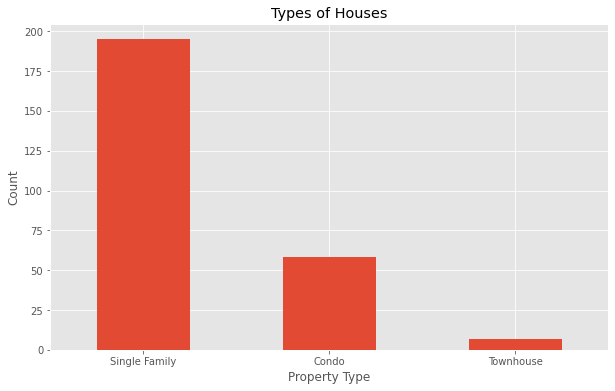

In [8]:
# Creating a bar chart showing the breakdown of the different types of houses (single family, townhouse, condo).
train['PropType'].value_counts().plot(kind='bar', rot=0)
plt.title('Types of Houses')
plt.xlabel("Property Type")
plt.ylabel("Count")
plt.savefig('House-Type-Bar-Chart')
plt.show()

In [9]:
# Computing the correlation matrix.
train_subset = train[['Acres', 'LstPrice', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt', 'PropType']]
train_corr = train.corr()
train_corr

,Acres,Deck,GaragCap,Latitude,Longitude,LstPrice,Patio,PkgSpacs,SoldPrice,Taxes,TotBed,TotBth,TotSqf,YearBlt,Prop_Type_num
Acres,1.000000,0.166535,0.452265,0.565715,0.242940,0.718336,0.007261,0.176664,0.711958,0.680737,0.594395,0.508805,0.740974,0.100823,0.555889
Deck,0.166535,1.000000,0.080732,0.188524,0.016205,0.161625,0.751281,0.030615,0.158344,0.115316,0.116709,0.105799,0.171394,0.126259,0.073426
GaragCap,0.452265,0.080732,1.000000,0.321907,0.084631,0.635873,-0.046058,-0.024399,0.626637,0.629935,0.358216,0.599209,0.573266,0.460012,0.025132
Latitude,0.565715,0.188524,0.321907,1.000000,-0.252189,0.362788,-0.027318,0.171773,0.366947,0.334774,0.289318,0.295843,0.409485,0.325981,0.297685
Longitude,0.242940,0.016205,0.084631,-0.252189,1.000000,0.388738,0.049541,0.038139,0.390691,0.358819,0.329295,0.151271,0.288552,-0.234680,0.334154
LstPrice,0.718336,0.161625,0.635873,0.362788,0.388738,1.000000,-0.012415,0.157512,0.995096,0.882305,0.661516,0.738907,0.870339,0.189212,0.387141
Patio,0.007261,0.751281,-0.046058,-0.027318,0.049541,-0.012415,1.000000,-0.033486,-0.008498,-0.032971,0.015951,-0.055505,-0.013220,-0.027119,0.079661
PkgSpacs,0.176664,0.030615,-0.024399,0.171773,0.038139,0.157512,-0.033486,1.000000,0.143800,0.088831,0.197178,0.135707,0.183647,-0.170515,0.244818
SoldPrice,0.711958,0.158344,0.626637,0.366947,0.390691,0.995096,-0.008498,0.143800,1.000000,0.877551,0.656926,0.727001,0.860303,0.184288,0.394914
Taxes,0.680737,0.115316,0.629935,0.334774,0.358819,0.882305,-0.032971,0.088831,0.877551,1.000000,0.561860,0.727997,0.818889,0.290080,0.252252


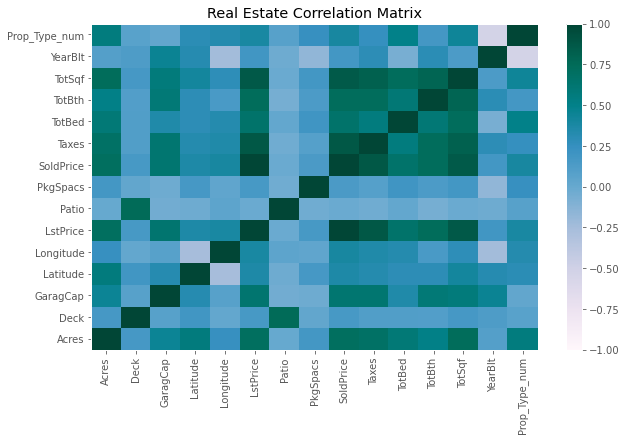

In [10]:
# Generating a heat map to visualize the correlation coefficients.
fig, ax = plt.subplots()
heatmap = plt.pcolor(train_corr, cmap=plt.cm.PuBuGn, vmin = -1, vmax = 1)
xy = train_corr.columns.tolist()
plt.xticks(np.arange(0.5, len(xy), 1), xy, rotation = 'vertical')
plt.yticks(np.arange(0.5, len(xy), 1), xy)
plt.title("Real Estate Correlation Matrix")
plt.colorbar(heatmap)
plt.savefig('Real-Estate-Correlation-Matrix')

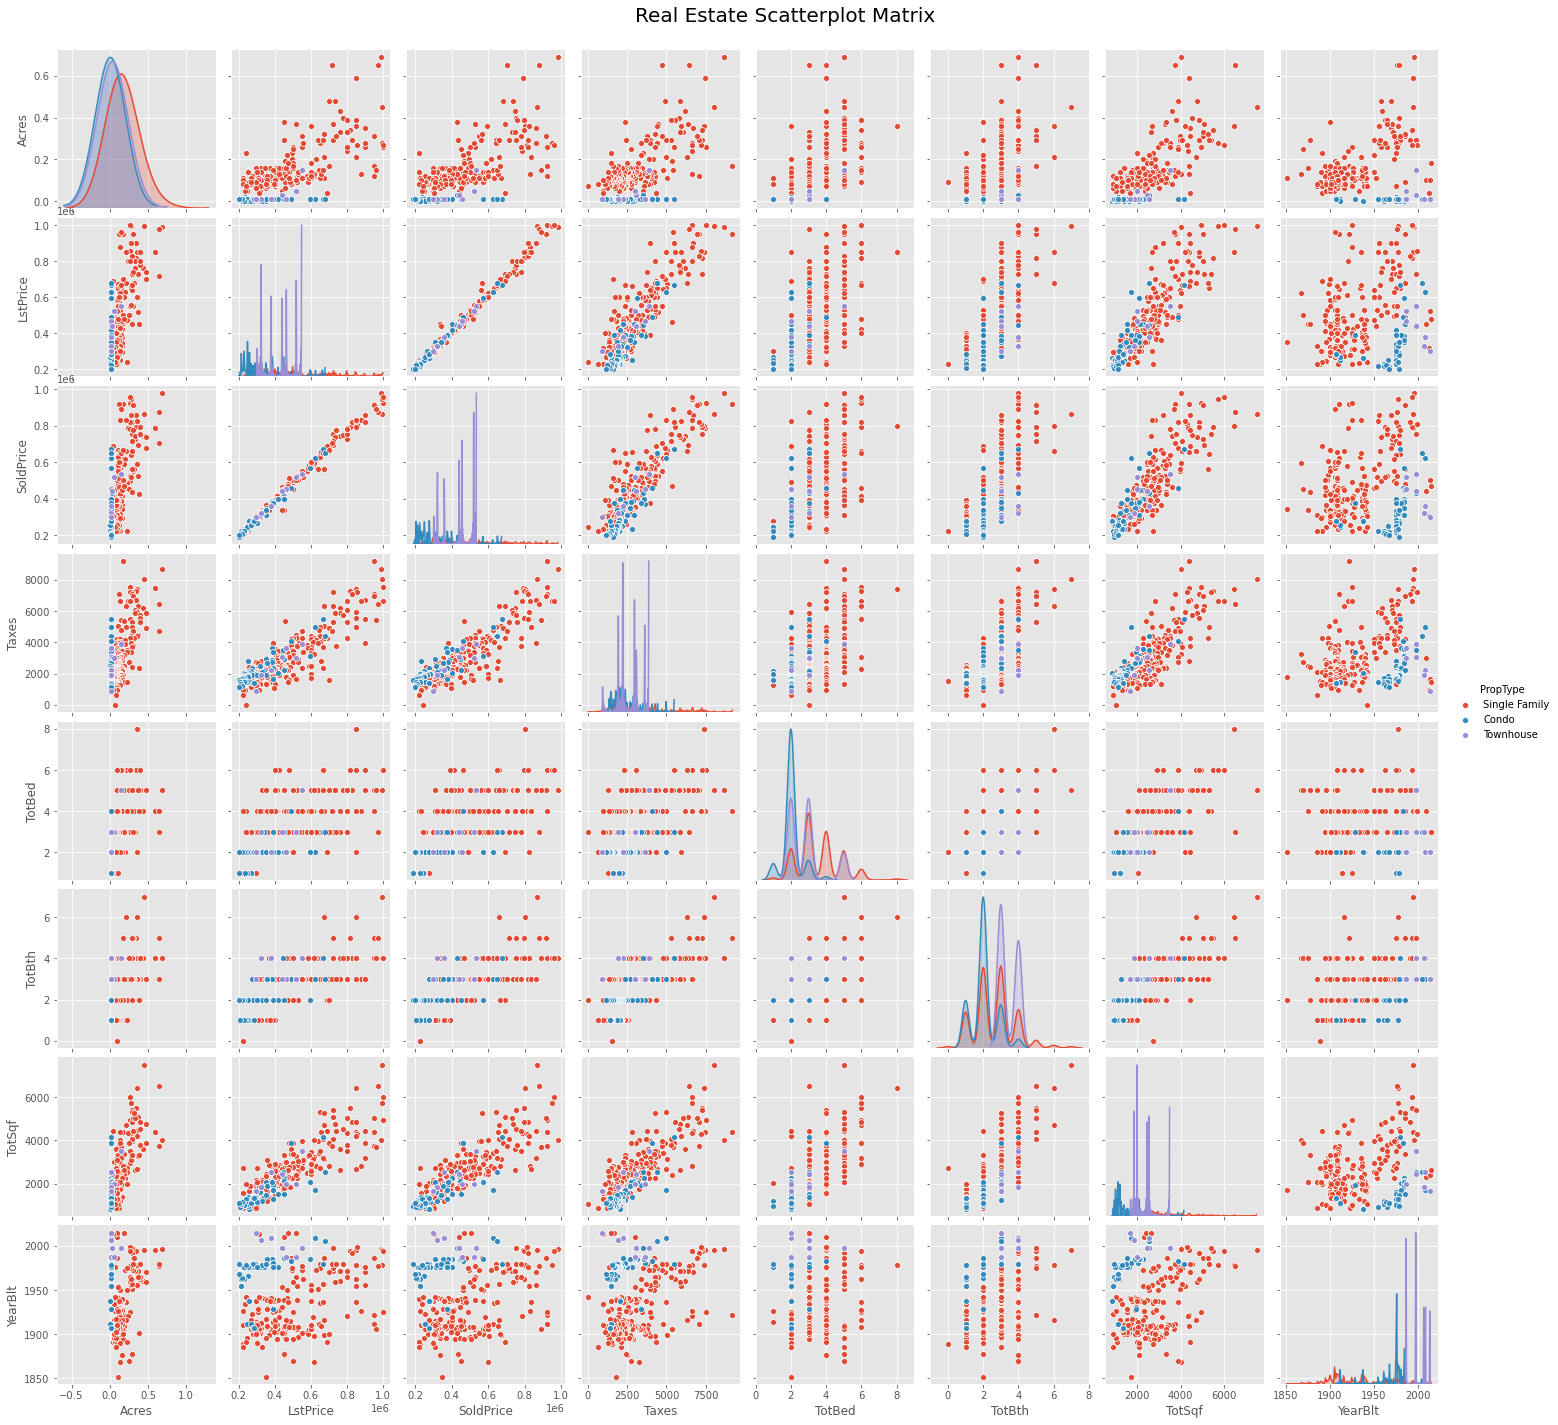

In [11]:
# Making a scatter plot matrix to visualize the correlations to determine which columns have strong correlations.
import seaborn as sns

rel = sns.pairplot(data = train_subset, hue="PropType", diag_kws={'bw': 0.2})

# Move title up
rel.fig.subplots_adjust(top=.95)

# Add overall title
rel.fig.suptitle('Real Estate Scatterplot Matrix', fontsize = 20)

plt.savefig('real-estate-scatter.png')

In our exploratory analysis, there are 260 observations and 18 variables in the train dataset. Based on the correlation scatterplot, the columns with the strongest correlation is the LstPrice and the SoldPrice. The plot is almost a linear line. Additionally, there are more that own a Single Family then any other Property Type.

## Analysis Tools

### Geospatial plot
Geospatial data defines specific geographical locations, either in the form of latitude and longitude coordinates or text fields with names of geographical areas, such as countries or states. Geospatial charts combine geospatial data with other forms of data to create map-based charts.

Two of the variables are the latitude and longitude of each listing. Salt Lake City is on a east-west, north-south grid, so even a simple plot of latitutde and longitude makes sense. Thus, we will be creating a scatterplot of these two variables.

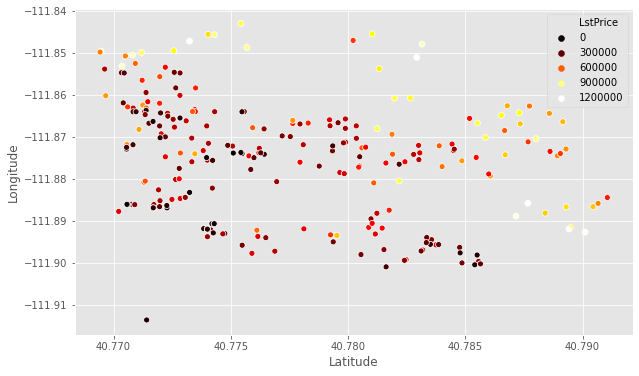

In [21]:
rel2 = sns.scatterplot(train['Latitude'], train['Longitude'], hue = train['LstPrice'], palette = 'hot')

# Move title up
# rel2.fig.subplots_adjust(top=.95)

# Add overall title
# rel2.fig.suptitle('Real Estate Geospatial Plot', fontsize = 20)

plt.savefig('real-estate-geospatial.png')

As we can see from the chart, the bigger the longitude and lattitude, the higher the price is for the house. Houses closer to (-111.91, 40.770) are cheaper in price.

### Linear Regression

We will now create a linear regression model to regress the Sold price on some of the other variables.

$$
\text{Sold Price} = \beta_0 + \beta_1 x
$$
where $x$ is one of the other variables. 

After we run the regression, we will make a scatterplot of list price vs sold price and overlay the prediction with the regression model. 

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 2.611e+04
Date:                Thu, 21 Jul 2022   Prob (F-statistic):          2.97e-261
Time:                        13:50:46   Log-Likelihood:                -2927.2
No. Observations:                 260   AIC:                             5858.
Df Residuals:                     258   BIC:                             5866.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.317e+04   2948.953      4.465      0.0

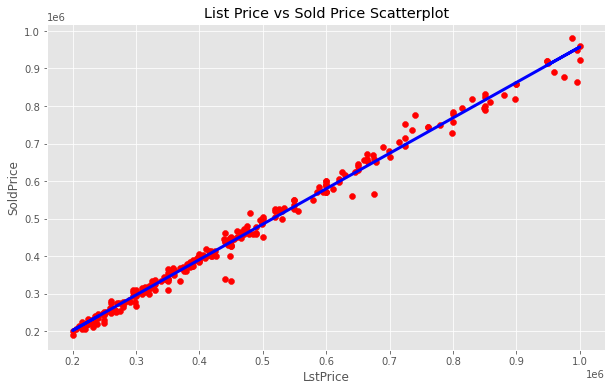

In [15]:
# Regression Model
uni_mod = sm.ols(formula="SoldPrice ~ LstPrice", data = train)
uni_result = uni_mod.fit()
print(uni_result.summary())

# Scatterplot
plt.scatter(train['LstPrice'], train['SoldPrice'],  color='red')
plt.xlabel("LstPrice")
plt.ylabel("SoldPrice")
plt.title('List Price vs Sold Price Scatterplot')
plt.plot(train['LstPrice'], uni_result.predict(),'k',color='blue',linewidth=3)
plt.savefig('lstprice-soldprice-scatter.png')

Based on the OLS Regression, the R-squared is 0.988. This is saying that the 98.8% of the variation is explained in the model. The Beta one of LstPrice is 0.9019. In other words, as LstPrice goes up by 1, SoldPrice increases by 0.9019 points.

### Multilinear Regression

We now develop a multilinear regression model for house prices in this neighborhood. We could use this to come up with a list price for houses coming on the market, so will not be including the list price in our model and also ignore the categorical variable Prop_Type. Our model is now in the form:
$$
\text{Sold Price} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots +  \beta_n x_n
$$
where $x_i$ are predictive variables.

Next we look at the difference between list price and sold price explicitly and calculate two new columns for our dataset. `DiffPriceAbsolute` and `DiffPriceRelative`.

* `DiffPriceAbsolute` - This is difference between sold price and list price. If it is positive, that means the house sold for more than it was listed at.
* `DiffPriceRelative` - This is the relative difference between sold price and list price. A value of 1.1 here means that the house sold for 110% of the asking price, and 0.9 means the house sold for 90% of the asking price.

After that, we create two new models. One to predict `DiffPriceAbsolute`, and one to predict `DiffPriceRelative` and use the same predictive variables as i the last model. From there, we compare which of the two new models makes better predictions.


From the two models, we will train two models to predict `DiffPriceAbsolute` and `DiffPriceRelative` based on just `SoldPrice` and create a scatterplot for each model.

In [16]:
# Generate Variables
train['DiffPriceAbsolute'] = train['SoldPrice'] - train['LstPrice']
train['DiffPriceRelative'] = train['SoldPrice'] / train['LstPrice']  

# Run Multilinear Regressions
uni_mod0 = sm.ols(formula="SoldPrice ~ Acres + Taxes + TotBed + TotBth + TotSqf + YearBlt", data = train)
uni_result0 = uni_mod0.fit()
print(uni_result0.summary())

uni_mod1 = sm.ols(formula="DiffPriceAbsolute ~ Acres + Taxes + TotBed + TotBth + TotSqf + YearBlt", data = train)
uni_result1 = uni_mod1.fit()
print(uni_result1.summary())

uni_mod2 = sm.ols(formula="DiffPriceRelative ~ Acres + Taxes + TotBed + TotBth + TotSqf + YearBlt", data = train)
uni_result2 = uni_mod2.fit()
print(uni_result2.summary())

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     218.7
Date:                Thu, 21 Jul 2022   Prob (F-statistic):           4.45e-97
Time:                        13:51:02   Log-Likelihood:                -3291.9
No. Observations:                 260   AIC:                             6598.
Df Residuals:                     253   BIC:                             6623.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.765e+05   2.94e+05      0.942      0.3

(26, 1) (26,)
(234, 1) (234,)
m= 1 , train:  0.044183253750189944  test:  0.1558863916734865


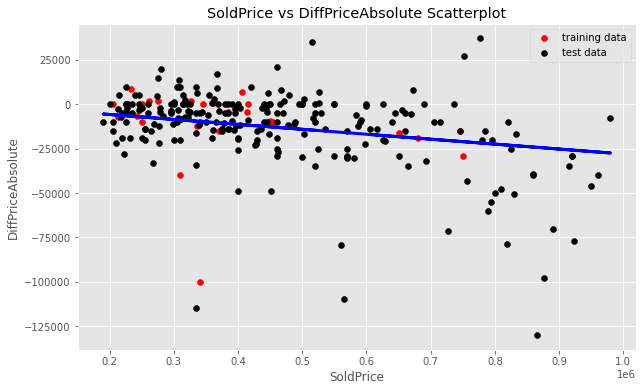

(26, 1) (26,)
(234, 1) (234,)
m= 1 , train:  0.0027093910644757635  test:  0.017034634806955773


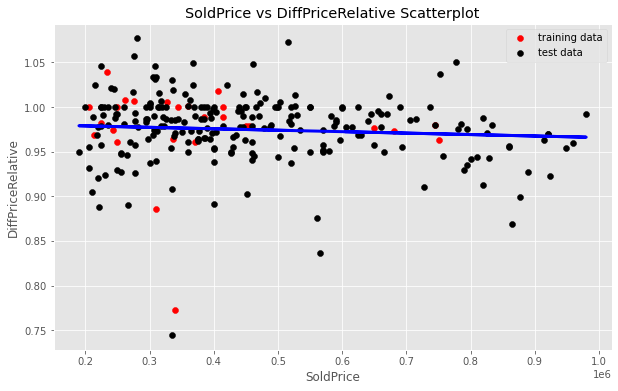

In [17]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
lr = linear_model.LinearRegression()

# Generate Values
X = train[['SoldPrice']].values
y = train['DiffPriceAbsolute'].values

# Split data into training data and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

for m in np.arange(1,2):     
    lr.fit(X=X_train[:,:m], y=y_train)
    print('m=', m, ', train: ', lr.score(X_train[:,:m], y_train), ' test: ', lr.score(X_test[:,:m], y_test))

# Scatterplot for SoldPrice & DiffPriceAbsolute
plt.scatter(X_train[:,0], y_train,  color='red',label='training data')
plt.scatter(X_test[:,0], y_test,  color='black',label='test data')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.title('SoldPrice vs DiffPriceAbsolute Scatterplot')
plt.legend()
plt.xlabel('SoldPrice'); plt.ylabel('DiffPriceAbsolute')
plt.savefig('DiffPriceAbsolute')
plt.show()

# Generate Values
X = train[['SoldPrice']].values
y = train['DiffPriceRelative'].values

# Split data into training data and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

for m in np.arange(1,2):     
    lr.fit(X=X_train[:,:m], y=y_train)
    print('m=', m, ', train: ', lr.score(X_train[:,:m], y_train), ' test: ', lr.score(X_test[:,:m], y_test))

# Scatterplot for SoldPrice & DiffPriceRelative
plt.scatter(X_train[:,0], y_train,  color='red',label='training data')
plt.scatter(X_test[:,0], y_test,  color='black',label='test data')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.title('SoldPrice vs DiffPriceRelative Scatterplot')
plt.legend()
plt.xlabel('SoldPrice'); plt.ylabel('DiffPriceRelative')
plt.savefig('DiffPriceRelative')
plt.show()

The multilinear regression model has a lower R squared than the simple linear regression model including the List Price. Therefore, there is more of the variation explained by the simple regression model. Additionally, based on the two models, the model that predicts the DiffPriceAbsolute is better than the model that predicts the DiffPriceRelative because the R squared is greater. Furthermore, from the different trained plots, the plot for the DiffPriceAbsolute has more plots closer to the linear line, thus shows the why more of the variation is explained. Although DiffPriceAbsolute is better, it still doesn't have a high R squared.

#### Incorporating a Categorical Variable

Above, we considered houses, townhouses, and condos together, but here 

We will now distinguish the difference between houses, townhouses, and condows. Consider the two regression models: 

$$
\text{SoldPrice} = \beta_0 + \beta_1 \text{Prop_Type_num}
$$
and 
$$
\text{SoldPrice} = \beta_0  + \beta_1 \text{Prop_Type_num} + \beta_2 \text{TotSqf}
$$

From the first model, it would appear that Property type is significant in predicting the sold price. On the other hand, the second model indicates that when we take into account total square footage, property type is no longer predictive. 

We will also make a scatterplot of TotSqf vs. SoldPrice where the house types are colored differently to illustrate your explanation. 

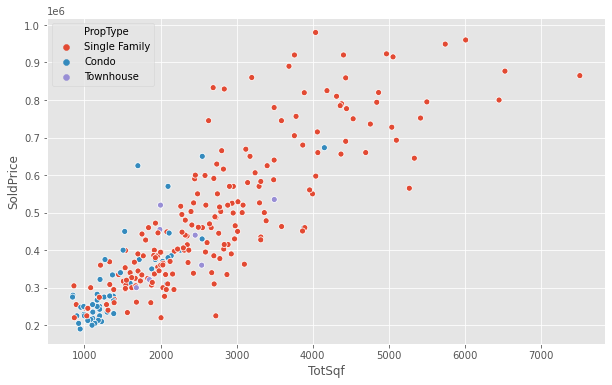

In [20]:
rel3 = sns.scatterplot(train['TotSqf'], train['SoldPrice'], hue = train['PropType'])

# Move title up
# rel3.fig.subplots_adjust(top=.95)

# Add overall title
# rel3.fig.suptitle('Total Square Ft vs Sold Price Scatterplot', fontsize = 20)

plt.savefig('TotSqf-SoldPrice-Scatter.png')

Based on the scatterplot, there seems to be a strong positive correlation between TotSqf and SoldPrice. The greater the total square feet, the higher the price. It is the same for all types of properties.